<ipython-input-1-368a626f7646>:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_values = np.array([spi.quad(integrand, 0, t)[0] for t in x])
/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:611: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
<ipython-input-1-368a626f7646>:43: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in orde

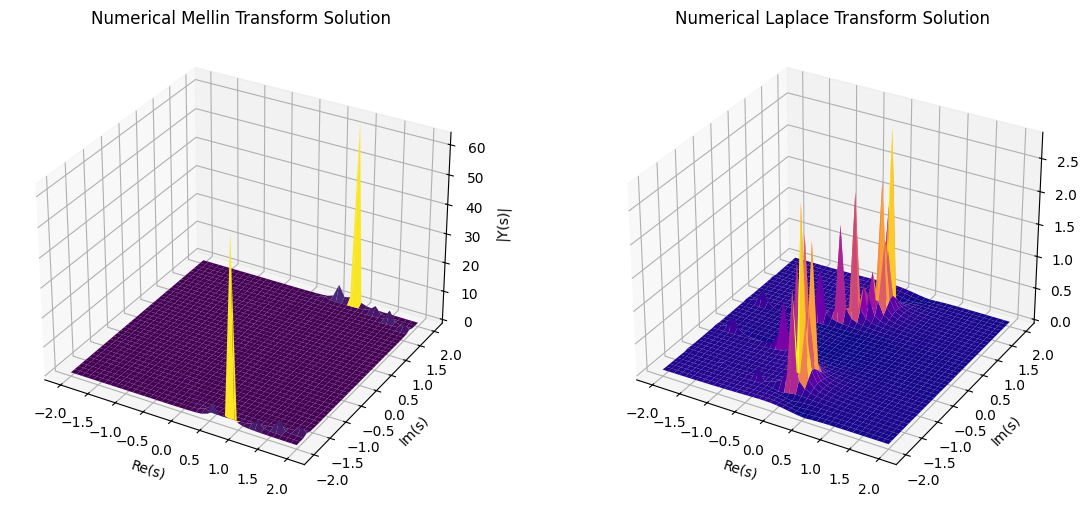

In [1]:
import numpy as np
import scipy.integrate as spi
import scipy.interpolate as interp
import matplotlib.pyplot as plt

# === 1. Define the Integro-Differential Equation ===
def forcing_function(x):
    return np.heaviside(x, 1)  # Heaviside step function u(t)

def integral_term(x, y_values):
    """Numerically approximate \int_0^t x(\tau)/\tau d\tau"""
    integrand = lambda tau: y_values[np.searchsorted(x, tau, side='left')] / (tau + 1e-8)
    integral_values = np.array([spi.quad(integrand, 0, t)[0] for t in x])
    return interp.interp1d(x, integral_values, kind='quadratic', fill_value='extrapolate')

# === 2. Solve the Integro-Differential Equation Numerically ===
def integro_differential_eq(t, y, integral_func):
    y1, y2 = y  # y1 = x, y2 = dx/dt
    integral_value = integral_func(t)
    dy1dt = y2
    dy2dt = (forcing_function(t) - 3 * t * y1 - 4 * integral_value) / (t**2 + 1e-8)
    return [dy1dt, dy2dt]

# Solve the system numerically
t_range = np.linspace(0.1, 4, 100)  # Avoid zero singularity
x_init = [1, -1]  # Initial conditions
sol = spi.solve_ivp(lambda t, y: integro_differential_eq(t, y, lambda t: 0),
                     [t_range[0], t_range[-1]], x_init, t_eval=t_range)

y_numeric = interp.interp1d(sol.t, sol.y[0], kind='quadratic', fill_value='extrapolate')
integ_func = integral_term(t_range, sol.y[0])

# === 3. Compute Mellin and Laplace Transforms ===
def numerical_derivative(func, x, order=1, dx=1e-5):
    if order == 1:
        return (func(x + dx) - func(x - dx)) / (2 * dx)
    elif order == 2:
        return (func(x + dx) - 2 * func(x) + func(x - dx)) / (dx ** 2)
    else:
        raise ValueError("Only first and second derivatives supported")

def mellin_transform_numeric(func, s, x_min=0.1, x_max=4):
    integral, _ = spi.quad(lambda x: x**(s-1) * func(x), x_min, x_max)
    return integral

def laplace_transform_numeric(func, s, x_min=0, x_max=4):
    integral, _ = spi.quad(lambda x: np.exp(-s*x) * func(x), x_min, x_max)
    return integral

# Generate transformed data
s_values = np.linspace(-2, 2, 40) + 1j * np.linspace(-2, 2, 40)[:, None]

# Compute Mellin transforms
mellin_y_values = np.array([[mellin_transform_numeric(y_numeric, s) for s in row] for row in s_values])
mellin_y_prime_values = np.array([[mellin_transform_numeric(lambda x: numerical_derivative(y_numeric, x, 1), s) for s in row] for row in s_values])
mellin_integral_values = np.array([[mellin_transform_numeric(lambda x: integ_func(x), s) for s in row] for row in s_values])

# Compute Laplace transforms
laplace_y_values = np.array([[laplace_transform_numeric(y_numeric, s) for s in row] for row in s_values])
laplace_y_prime_values = np.array([[laplace_transform_numeric(lambda x: numerical_derivative(y_numeric, x, 1), s) for s in row] for row in s_values])
laplace_integral_values = np.array([[laplace_transform_numeric(lambda x: integ_func(x), s) for s in row] for row in s_values])

# Compute numerical transformed solutions
Y_mellin_numeric = mellin_y_values / (mellin_y_prime_values + 3 * mellin_y_values + 4 * mellin_integral_values)
Y_laplace_numeric = laplace_y_values / (laplace_y_prime_values + 3 * laplace_y_values + 4 * laplace_integral_values)

# === 5. Plot the Numerical Solutions ===
fig = plt.figure(figsize=(14, 6))

# Mellin Transform Surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(s_values.real, s_values.imag, np.abs(Y_mellin_numeric), cmap='viridis')
ax1.set_title("Numerical Mellin Transform Solution")
ax1.set_xlabel("Re(s)")
ax1.set_ylabel("Im(s)")
ax1.set_zlabel("|Y(s)|")

# Laplace Transform Surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(s_values.real, s_values.imag, np.abs(Y_laplace_numeric), cmap='plasma')
ax2.set_title("Numerical Laplace Transform Solution")
ax2.set_xlabel("Re(s)")
ax2.set_ylabel("Im(s)")
ax2.set_zlabel("|Y(s)|")

plt.show()


## now try to train NN on them and see which is easier/ better

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Define the Neural Network ===
class TransformNet(nn.Module):
    def __init__(self):
        super(TransformNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),  # Extra hidden layer
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [3]:
def train_surface(X_values, Y_values, num_epochs=500, batch_size=32, learning_rate=0.0005):
    """
    Train a neural network on a given transformed surface.

    Parameters:
    - X_values: (N, 2) NumPy array of (Re(s), Im(s)) points.
    - Y_values: (N, 1) NumPy array of |Y(s)| values (from Mellin or Laplace).
    - num_epochs: Number of training epochs.
    - batch_size: Training batch size.
    - learning_rate: Learning rate for optimizer.

    Returns:
    - model: Trained PyTorch neural network.
    - losses: Training loss history.
    """
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_values, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_values, dtype=torch.float32).unsqueeze(1)

    # Create DataLoader
    dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, optimizer, loss function
    model = TransformNet()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_X, batch_Y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss = {avg_loss:.6f}")

    # Plot training loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(num_epochs), losses, label="Training Loss", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training Loss Curve")
    plt.show()

    return model, losses

Epoch 0: Loss = 4.994136
Epoch 20: Loss = 4.703355
Epoch 40: Loss = 4.333577
Epoch 60: Loss = 4.273185
Epoch 80: Loss = 4.040237
Epoch 100: Loss = 3.230561
Epoch 120: Loss = 2.703013
Epoch 140: Loss = 2.839698
Epoch 160: Loss = 3.335824
Epoch 180: Loss = 3.040721
Epoch 200: Loss = 1.148627
Epoch 220: Loss = 2.083130
Epoch 240: Loss = 1.169333
Epoch 260: Loss = 0.592937
Epoch 280: Loss = 0.058242
Epoch 300: Loss = 0.102758
Epoch 320: Loss = 4.031156
Epoch 340: Loss = 3.584328
Epoch 360: Loss = 3.067747
Epoch 380: Loss = 3.306915
Epoch 400: Loss = 2.281723
Epoch 420: Loss = 1.701620
Epoch 440: Loss = 1.148151
Epoch 460: Loss = 0.414131
Epoch 480: Loss = 2.450563


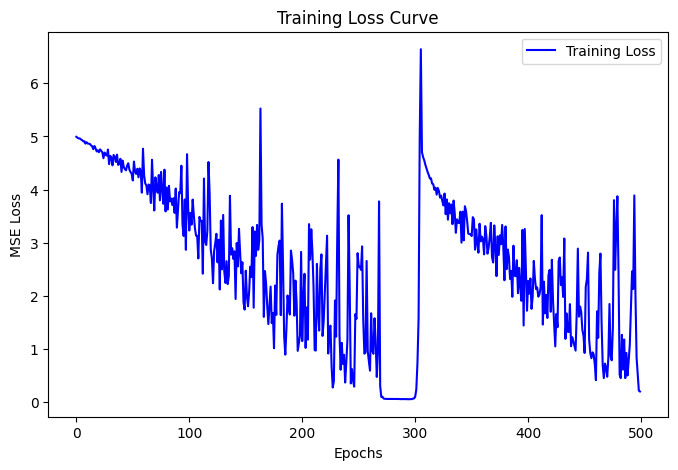

In [4]:
# Example: Train on the Mellin Transform Surface
X_mellin = np.column_stack((s_values.real.flatten(), s_values.imag.flatten()))
Y_mellin = np.abs(Y_mellin_numeric.flatten())

model_mellin, losses_mellin = train_surface(X_mellin, Y_mellin)

Epoch 0: Loss = 0.032342
Epoch 20: Loss = 0.022982
Epoch 40: Loss = 0.019431
Epoch 60: Loss = 0.017867
Epoch 80: Loss = 0.013801
Epoch 100: Loss = 0.012169
Epoch 120: Loss = 0.008152
Epoch 140: Loss = 0.010393
Epoch 160: Loss = 0.005209
Epoch 180: Loss = 0.011901
Epoch 200: Loss = 0.012542
Epoch 220: Loss = 0.009047
Epoch 240: Loss = 0.005094
Epoch 260: Loss = 0.004811
Epoch 280: Loss = 0.014356
Epoch 300: Loss = 0.002206
Epoch 320: Loss = 0.002715
Epoch 340: Loss = 0.007022
Epoch 360: Loss = 0.005802
Epoch 380: Loss = 0.002478
Epoch 400: Loss = 0.013038
Epoch 420: Loss = 0.000537
Epoch 440: Loss = 0.000539
Epoch 460: Loss = 0.000188
Epoch 480: Loss = 0.013087


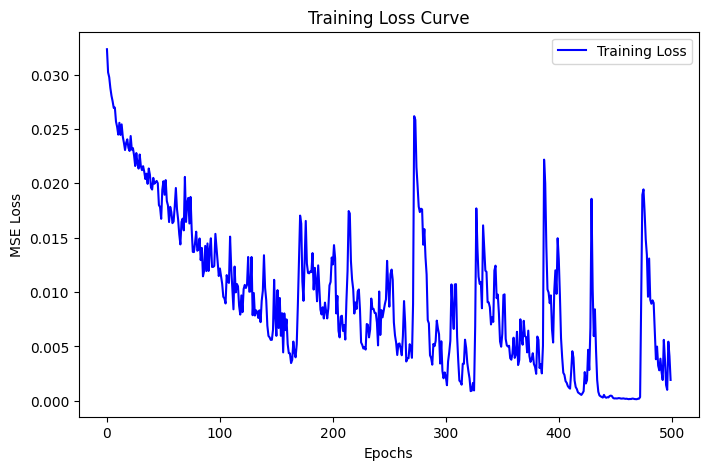

In [5]:


# Example: Train on the Laplace Transform Surface
X_laplace = np.column_stack((s_values.real.flatten(), s_values.imag.flatten()))
Y_laplace = np.abs(Y_laplace_numeric.flatten())

model_laplace, losses_laplace = train_surface(X_laplace, Y_laplace)

In [6]:
torch.save(model_mellin.state_dict(), "model_mellin.pth")
torch.save(model_laplace.state_dict(), "model_laplace.pth")

In [7]:
# Recreate the model architecture
model_mellin = TransformNet()
model_laplace = TransformNet()

# Load the saved weights
model_mellin.load_state_dict(torch.load("model_mellin.pth"))
model_laplace.load_state_dict(torch.load("model_laplace.pth"))

# Set to evaluation mode
model_mellin.eval()
model_laplace.eval()

<ipython-input-7-6f83b5bdaf60>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mellin.load_state_dict(torch.load("model_mellin.pth"))
<ipython-input-7-6f83b5bdaf60>:7

TransformNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

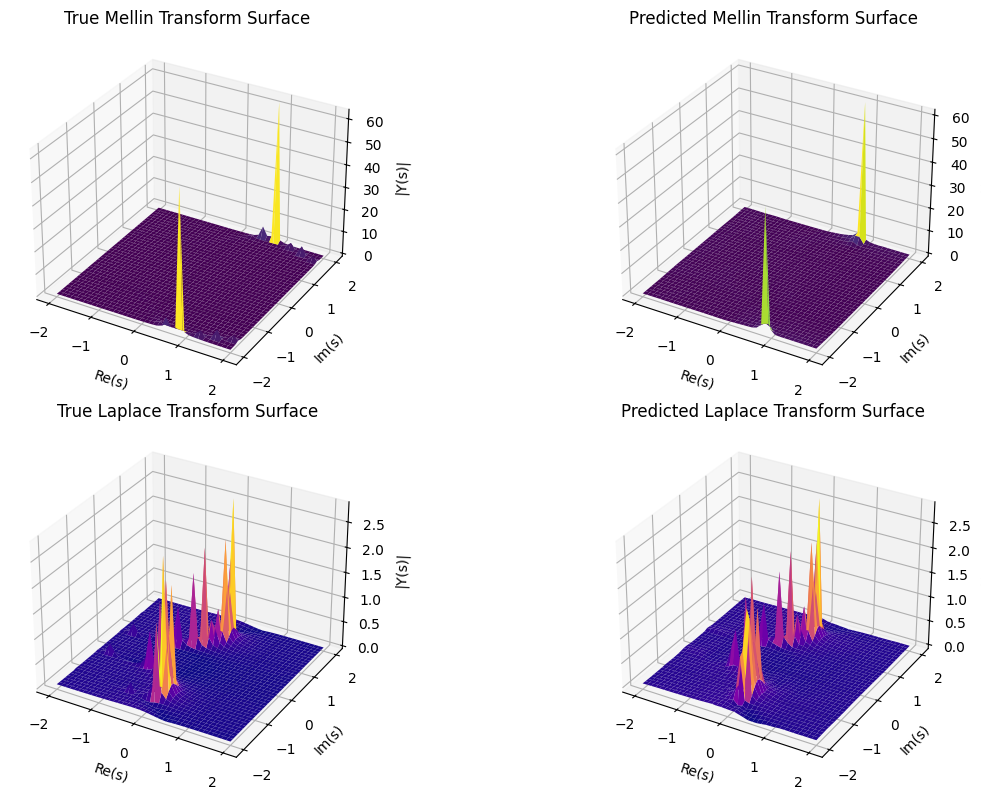

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function to generate predictions from the trained network
def predict_surface(model, X_values):
    """Generate predictions from a trained neural network."""
    with torch.no_grad():
        X_tensor = torch.tensor(X_values, dtype=torch.float32)
        Y_pred = model(X_tensor).numpy().reshape(s_values.shape)  # Reshape to match original surface
    return Y_pred

# Prepare input for predictions
X_mellin = np.column_stack((s_values.real.flatten(), s_values.imag.flatten()))
X_laplace = np.column_stack((s_values.real.flatten(), s_values.imag.flatten()))

# Predict Mellin and Laplace surfaces using trained models
Y_mellin_pred = predict_surface(model_mellin, X_mellin)
Y_laplace_pred = predict_surface(model_laplace, X_laplace)

# === Plot comparison: True vs. Predicted surfaces ===
fig = plt.figure(figsize=(14, 8))

# True Mellin Transform Surface
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(s_values.real, s_values.imag, np.abs(Y_mellin_numeric), cmap='viridis')
ax1.set_title("True Mellin Transform Surface")
ax1.set_xlabel("Re(s)")
ax1.set_ylabel("Im(s)")
ax1.set_zlabel("|Y(s)|")

# Predicted Mellin Transform Surface
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(s_values.real, s_values.imag, Y_mellin_pred, cmap='viridis')
ax2.set_title("Predicted Mellin Transform Surface")
ax2.set_xlabel("Re(s)")
ax2.set_ylabel("Im(s)")
ax2.set_zlabel("|Y(s)|")

# True Laplace Transform Surface
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(s_values.real, s_values.imag, np.abs(Y_laplace_numeric), cmap='plasma')
ax3.set_title("True Laplace Transform Surface")
ax3.set_xlabel("Re(s)")
ax3.set_ylabel("Im(s)")
ax3.set_zlabel("|Y(s)|")

# Predicted Laplace Transform Surface
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(s_values.real, s_values.imag, Y_laplace_pred, cmap='plasma')
ax4.set_title("Predicted Laplace Transform Surface")
ax4.set_xlabel("Re(s)")
ax4.set_ylabel("Im(s)")
ax4.set_zlabel("|Y(s)|")

plt.tight_layout()
plt.show()